### Resnet18, simplified with 2.8m params since the input dataset is simpler one than imagenet
Channel normalisation, image augmentation, random erasing and cyclic LR

Best accuracy in 150 epochs is 87.34%, with full resnet18 of 11m params, it is 2% less

In [0]:
import numpy as np
import keras
import math

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Add, GlobalAveragePooling2D
from keras.layers import Conv2D, Convolution2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.layers.merge import add
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras.utils import np_utils
from keras.regularizers import l2

from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from matplotlib import pyplot as plt
%matplotlib inline

from google.colab import drive
#drive.mount('/content/gdrive')
dir="/content/gdrive/My Drive/Colab Notebooks/EVA/Session11_20/"
!ls

batch_size = 128

# input image dimensions
img_rows, img_cols = 32, 32
img_channels = 3
nb_classes = 10

Using TensorFlow backend.


sample_data


### Load pre-shuffled CIFAR data into train and test sets


In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
label_dict = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}
print(X_train.shape)
print(X_test.shape)
print(X_train[0,0,0,:])

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# Pixel standardisation
X_train /= 255
X_test /= 255
print(X_train[0,0,0,:])

# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
print(Y_train.shape)

170500096/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)
[59 62 63]
[0.23137255 0.24313726 0.24705882]
(50000, 10)


#### Displaying images

Steps : 391 79
(128, 32, 32, 3)


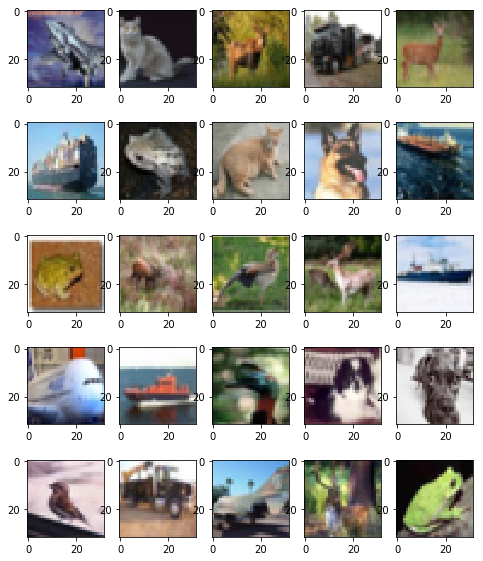

In [0]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_gen = train_datagen.flow(X_train, Y_train, batch_size=batch_size, shuffle=True, seed=42)
test_gen = test_datagen.flow(X_test, Y_test, batch_size=batch_size, shuffle=True, seed=42)

train_steps = len(train_gen)
test_steps = len(test_gen)
print("Steps :",train_steps, test_steps)

for i in range(15):
    x_batch, y_batch = next(train_gen)
print(x_batch.shape)

# Plot Generator images
fig = plt.figure(figsize=(8, 10)) # width,height

for i in range(25):
    sub = fig.add_subplot(5, 5, i + 1) # nrows, ncols, index
      
    sub.imshow(x_batch[i,:,:], interpolation='nearest')

In [0]:
def get_img_mean(img_dataset):
  #print(img_dataset.shape)
  avg = np.mean(img_dataset)
  return avg

val_for_cutout = get_img_mean(X_train)
print(val_for_cutout)

0.4733649


#### Channel normalisation

In [0]:
#X_train_mean = np.mean(X_train, axis=(0,1,2))
#X_train_std = np.std(X_train, axis=(0,1,2))
X_train_mean = np.array([0.4914, 0.4822, 0.4465])
X_train_std = np.array([0.2023, 0.1994, 0.2010])

X_train = (X_train - X_train_mean) / X_train_std
print(X_train[0,0,0,:])
X_test = (X_test - X_train_mean) / X_train_std

[-1.28535566 -1.19891045 -0.99224466]


#### Random erasing with mean of the dataset for 50% images

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, pixel_val=0):
  
  def eraser(input_img):
    img_h, img_w, img_c = input_img.shape
    #print(input_img.shape)
    p_1 = np.random.rand()

    if p_1 > p:
      return input_img

    while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break
    #c = np.random.uniform(v_l, v_h)

    input_img[top:top + h, left:left + w, :] = pixel_val
    # print("Pixel",pixel_val)      
    # print("Patch size", h, w)
      
    return input_img
  return eraser

#### Displaying augmented images

Steps : 391 79


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

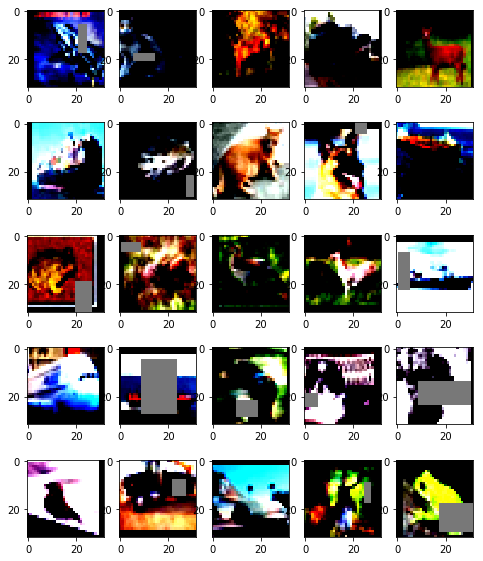

In [0]:
train_datagen = ImageDataGenerator(
        fill_mode = 'constant',
        cval=0,
        width_shift_range=4,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=4,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        preprocessing_function=get_random_eraser(pixel_val=val_for_cutout)
)
test_datagen = ImageDataGenerator()

train_gen = train_datagen.flow(X_train, Y_train, batch_size=batch_size, shuffle=True, seed=42)
test_gen = test_datagen.flow(X_test, Y_test, batch_size=batch_size, shuffle=True, seed=42)

train_steps = len(train_gen)
test_steps = len(test_gen)
print("Steps :",train_steps, test_steps)

for i in range(15):
    x_batch, y_batch = next(train_gen)
print(x_batch.shape)

# Plot Generator images
fig = plt.figure(figsize=(8, 10)) # width,height

for i in range(25):
    sub = fig.add_subplot(5, 5, i + 1) # nrows, ncols, index
      
    sub.imshow(x_batch[i,:,:], interpolation='nearest')

#### Resnet18 model
Conv(3,3)->Residual block1-> Residual block2->Residual block3->Residual block4.
Each Residual block has 2 basic blocks, each having 2 units of BN-Relu-Conv(3,3).

The first conv block has 16 input filters, first residual block has 32 filters, which is doubled for each subsequent residual blocks, with 4th block having 256 filters.

For each residual block, the first basic block shortcut has (1,1)conv and the second basic block shortcut has identity connection.

All conv blocks have stride (1,1) except the first conv. units of residual blocks 2, 3 and 4. They have strides and filters to match the residual dimensions in the shortcut for add function.

In [0]:
def bn_relu(input):  
    """Helper to build a BN -> relu block """
    norm = BatchNormalization(axis=3)(input)
    return Activation("relu")(norm)


def conv_bn_relu(input, **conv_params):
    """Helper to build a conv -> BN -> relu block """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))
   
    conv = Conv2D(filters=filters, kernel_size=kernel_size,
                  strides=strides, padding=padding, use_bias=False,
                  kernel_initializer=kernel_initializer,
                  kernel_regularizer=kernel_regularizer)(input)
    return bn_relu(conv)
  
  
def bn_relu_conv(input, **conv_params):
    """Helper to build a BN -> relu -> conv block."""
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    activation = bn_relu(input)
    conv = Conv2D(filters=filters, kernel_size=kernel_size,
                  strides=strides, padding=padding,
                  kernel_initializer=kernel_initializer,
                  kernel_regularizer=kernel_regularizer)(activation)
    return conv
  

def residual_block(filters, repetitions, is_first_block=False):
    """Builds a residual block with repeating basic blocks. """
    # Conv strides for the first unit of first basic block is (2,2) for residual blocks 2,3,4. All other strides are (1,1)
    
    def f(input):
      for i in range(repetitions):
        init_strides = (1, 1)
        if i == 0 and not is_first_block:
          init_strides = (2, 2)
        input = basic_block(input, filters=filters, init_strides=init_strides)        
      return input
        
    return f
  
  
def basic_block(input, filters, init_strides=(1, 1)):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34."""
    
    conv1 = bn_relu_conv(input, filters=filters, kernel_size=(3, 3), strides=init_strides)
    residual = bn_relu_conv(conv1, filters=filters, kernel_size=(3, 3))
    
    return shortcut(input, residual)
  
  
ROW_AXIS = 1
COL_AXIS = 2
CHANNEL_AXIS = 3

def shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum" """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity. Here 1x1 is used to increase the channels
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)        
    return add([shortcut, residual])  

In [0]:
def build_resnet(input_shape, num_outputs, repetitions):
        """Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_rows, nb_cols, nb_channels)")
            
        input = Input(shape=(input_shape[0], input_shape[1], input_shape[2],))
        init_filters = 16
        
        conv1 = conv_bn_relu(input, filters=init_filters, kernel_size=(3, 3), strides=(1,1))
        #pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)
        
        block = conv1
        filters = init_filters * 2
        for i, r in enumerate(repetitions):
            block = residual_block(filters=filters, repetitions=r, is_first_block=(i == 0))(block)
            #print(i, " RESIDUAL BLOCK END ", block.shape)
            filters *= 2

        # Last activation
        block = bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        #print("Average pool shape", pool2.shape)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

In [0]:
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        print("self.lr_mult", self.lr_mult)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
                
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
                
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            print(" LOSS EXPLODING")
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        print(" LR", lr)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])
        
    def plot_losses(self, n_skip=10):
        plt.rcParams["figure.figsize"] = (10, 5)
        plt.subplot(1, 2, 1)
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
        plt.subplot(1, 2, 2)         
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')

#### Find the starting LR

In [0]:
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

lr_finder = LR_Finder(start_lr=1e-4, end_lr=1e-1, step_size=train_steps)
model.fit_generator(train_gen, steps_per_epoch=len(train_gen), epochs=1, 
                    callbacks = [lr_finder]) 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

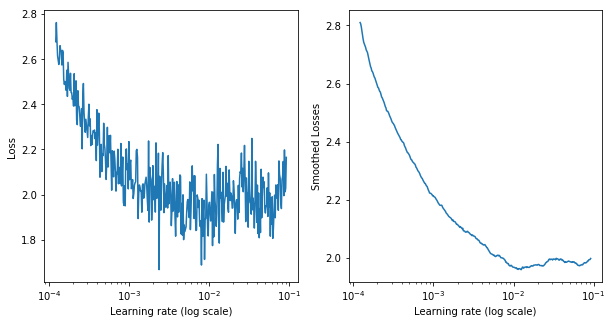

In [0]:
lr_finder.plot_losses()

#### Training with cyclic LR

In [0]:
!git clone "https://github.com/bckenstler/CLR.git"
!ls CLR

Cloning into 'CLR'...
remote: Enumerating objects: 244, done.
remote: Total 244 (delta 0), reused 0 (delta 0), pack-reused 244
Receiving objects: 100% (244/244), 1.37 MiB | 18.44 MiB/s, done.
Resolving deltas: 100% (86/86), done.
clr_callback.py  clr_callback_tests.ipynb  images  LICENSE  README.md


#### Taking starting lr at a point between 1e-2 and 1e-3, ie 5e-3 for max_lr and 5e-4 for base_lr
First 50 epochs - Best validation accuracy is **76.95% at epoch 48**, train accuracy is 75.07%

In [0]:
from CLR.clr_callback import *

#0.0005 to 0.005
clr = CyclicLR(base_lr=5e-4, max_lr=5e-3, step_size=2000., mode='triangular2')
sgd = SGD(lr=0.005, momentum=0.9)

model = build_resnet((img_rows, img_cols, img_channels), nb_classes, [2, 2, 2, 2])
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

file = dir + "Weights/Assign13_normal.{epoch:03d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model_info = model.fit_generator(train_gen, steps_per_epoch=len(train_gen), epochs=50, verbose=1,
                    validation_data=test_gen, validation_steps=len(test_gen), callbacks=[checkpoint, clr] )

Epoch 1/50
391/391 [==============================] - 61s 155ms/step - loss: 2.5738 - acc: 0.2324 - val_loss: 2.3785 - val_acc: 0.3163

Epoch 00001: val_acc improved from -inf to 0.31630, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Weights/Assign13_normal.001-0.3163.hdf5
Epoch 2/50
391/391 [==============================] - 57s 147ms/step - loss: 2.3204 - acc: 0.3254 - val_loss: 2.2281 - val_acc: 0.3592

Epoch 00002: val_acc improved from 0.31630 to 0.35920, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Weights/Assign13_normal.002-0.3592.hdf5
Epoch 3/50
391/391 [==============================] - 57s 146ms/step - loss: 2.1517 - acc: 0.3864 - val_loss: 2.0108 - val_acc: 0.4392

Epoch 00003: val_acc improved from 0.35920 to 0.43920, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Weights/Assign13_normal.003-0.4392.hdf5
Epoch 4/50
391/391 [==============================] - 57s 146ms/step - loss: 2.0208 - acc: 0.4332 - val_loss: 1.9553 - val_acc:

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(10,4))
    # Set axis properties [xmin, xmax, ymin, ymax]
    axs[0].axis([0,50,0.4,1])
    
    # Plot training & validation accuracy values
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Plot training & validation loss values
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()  
    

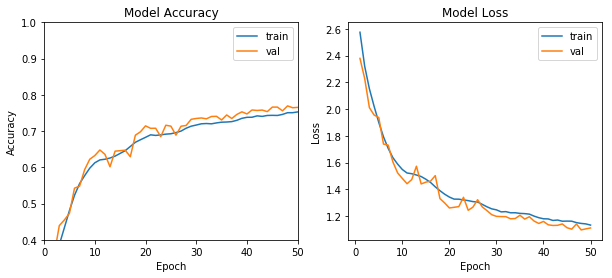

In [0]:
plot_model_history(model_info)

50-100 epochs - Best validation accuracy is **84.45% at epoch 100**, train accuracy is 85.11%

In [0]:
from CLR.clr_callback import *

#0.0005 to 0.005
clr = CyclicLR(base_lr=5e-4, max_lr=5e-3, step_size=2000., mode='triangular2')
sgd = SGD(lr=5e-3, momentum=0.9)

model = build_resnet((img_rows, img_cols, img_channels), nb_classes, [2, 2, 2, 2])
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.load_weights(dir + "Weights/Assign13_normal.048-0.7695.hdf5")
print("Loaded model from disk ")

file = dir + "Weights/Assign13_normal.{epoch:03d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopper = EarlyStopping(min_delta=0.0001, patience=12)

model_info = model.fit_generator(train_gen, steps_per_epoch=len(train_gen), initial_epoch=50, epochs=100,
                    validation_data=test_gen, validation_steps=len(test_gen), callbacks=[clr, checkpoint, early_stopper] )

Loaded model from disk 
Epoch 51/100
391/391 [==============================] - 60s 154ms/step - loss: 1.1424 - acc: 0.7503 - val_loss: 1.1396 - val_acc: 0.7508

Epoch 00051: val_acc improved from -inf to 0.75080, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Weights/Assign13_normal.051-0.7508.hdf5
Epoch 52/100
391/391 [==============================] - 57s 145ms/step - loss: 1.1610 - acc: 0.7441 - val_loss: 1.1779 - val_acc: 0.7396

Epoch 00052: val_acc did not improve from 0.75080
Epoch 53/100
391/391 [==============================] - 56s 144ms/step - loss: 1.1708 - acc: 0.7405 - val_loss: 1.1557 - val_acc: 0.7484

Epoch 00053: val_acc did not improve from 0.75080
Epoch 54/100
391/391 [==============================] - 57s 145ms/step - loss: 1.1729 - acc: 0.7385 - val_loss: 1.3988 - val_acc: 0.6684

Epoch 00054: val_acc did not improve from 0.75080
Epoch 55/100
391/391 [==============================] - 57s 145ms/step - loss: 1.1582 - acc: 0.7427 - val_loss: 1.2827 - 

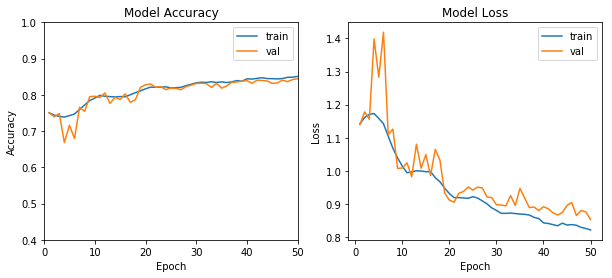

In [0]:
plot_model_history(model_info)

100-150 epochs - Best validation accuracy is **87.34% at epoch 142**, train accuracy is 89.83%

In [0]:
from CLR.clr_callback import *

#0.0005 to 0.005
clr = CyclicLR(base_lr=5e-4, max_lr=5e-3, step_size=2000., mode='triangular2')
sgd = SGD(lr=5e-4, momentum=0.9)

model = build_resnet((img_rows, img_cols, img_channels), nb_classes, [2, 2, 2, 2])
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.load_weights(dir + "Weights/Assign13_normal.100-0.8445.hdf5")
print("Loaded model from disk ")

file = dir + "Weights/Assign13_normal.{epoch:03d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopper = EarlyStopping(min_delta=0.0001, patience=12)

model_info = model.fit_generator(train_gen, steps_per_epoch=len(train_gen), initial_epoch=100, epochs=150,
                    validation_data=test_gen, validation_steps=len(test_gen), callbacks=[clr, checkpoint, early_stopper] )

Loaded model from disk 
Epoch 101/150
  3/391 [..............................] - ETA: 8:39 - loss: 0.8185 - acc: 0.8438 

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.271982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


391/391 [==============================] - 62s 159ms/step - loss: 0.8311 - acc: 0.8458 - val_loss: 0.9304 - val_acc: 0.8178

Epoch 00101: val_acc improved from -inf to 0.81780, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Weights/Assign13_normal.101-0.8178.hdf5
Epoch 102/150
391/391 [==============================] - 57s 147ms/step - loss: 0.8485 - acc: 0.8401 - val_loss: 1.0028 - val_acc: 0.8027

Epoch 00102: val_acc did not improve from 0.81780
Epoch 103/150
391/391 [==============================] - 57s 146ms/step - loss: 0.8711 - acc: 0.8300 - val_loss: 1.1019 - val_acc: 0.7729

Epoch 00103: val_acc did not improve from 0.81780
Epoch 104/150
391/391 [==============================] - 57s 146ms/step - loss: 0.8896 - acc: 0.8251 - val_loss: 0.9498 - val_acc: 0.8122

Epoch 00104: val_acc did not improve from 0.81780
Epoch 105/150
391/391 [==============================] - 57s 147ms/step - loss: 0.8953 - acc: 0.8203 - val_loss: 1.0332 - val_acc: 0.7878

Epoch 00105: val

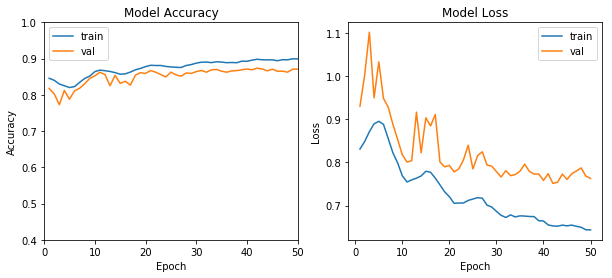

In [0]:
plot_model_history(model_info)